In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import models, transforms
from PIL import Image
from scipy.ndimage import gaussian_filter
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cpu for inference


In [7]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
denormalize = transforms.Normalize(mean = [-0.485/0.229, -0.456/0.224, -0.406/0.225], std = [1/0.229, 1/0.224, 1/0.225] )
def image_converter(im):
    im_copy = im.cpu()
    im_copy = denormalize(im_copy.clone().detach()).numpy()
    im_copy = im_copy.transpose(1,2,0)
    im_copy = im_copy.clip(0, 1) 
    return im_copy

def layer_hook(act_dict, layer_name):
    def hook(module, input, output):
        act_dict[layer_name] = output
    return hook

In [8]:
from numpy import asarray
def load_image(img_path, device=False):
    img = Image.open(img_path)
    img = img.resize((256, 256))
    img = img.convert('RGB')
    img = asarray(img).transpose(-1, 0, 1)
    img = img/255
    img = torch.from_numpy(img) 
    img = normalize(img)
    img = img.unsqueeze(0)
    img.requires_grad = True
    if device:
        img = img.type(torch.cuda.FloatTensor)
    else:
        img = img.type(torch.FloatTensor)
    return img

In [51]:
def act_max(model, 
    inp_img, 
    layer_activation, 
    layer_name, 
    unit, 
    steps=5, 
    alpha=torch.tensor(0.005),
    theta_decay=0.1,
    theta_every=4,
    theta_width=0.1,
    ):

    best_activation = -float('inf')
    best_img = inp_img
    for k in range(steps):
        inp_img.requires_grad_(True)
        inp_img.retain_grad() 
        old_norm = torch.norm(inp_img)
        
        # Propagate image
        model(inp_img)
        layer_out = layer_activation[layer_name]

        # Compute gradients
        layer_out[0][unit].backward(retain_graph=True)
        img_grad = inp_img.grad

        # Gradient Step
        inp_img = torch.add(inp_img, torch.mul(img_grad, alpha))

        new_norm = torch.norm(inp_img)
        inp_img = torch.mul(inp_img, old_norm/new_norm)

        # #L2_Decay
        # input = torch.mul(input, (1.0 - theta_decay))

        # #Gaussian Blur
        # if k % theta_every == 0:
        #   temp = input.squeeze(0)
        #   temp = temp.detach().numpy()
        #   for channel in range(3):
        #       cimg = gaussian_filter(temp[channel], theta_width)
        #       temp[channel] = cimg
        #   temp = torch.from_numpy(temp)
        #   input = temp.unsqueeze(0)

        # print('step: ', k, 'activation: ', layer_out[0][unit])
        # if k % 10 == 0:
        if k == steps - 1:
            final_image = image_converter(inp_img.squeeze(0))
            plt.imshow(final_image)
            plt.show()
            print('step: ', k, 'activation: ', layer_out[0][unit])

        # Keep highest activation
        # Some sort of penalization for high-activation-inputs generating high-activation-outputs: why 0.05? why linear?
        if layer_out[0][unit] - (0.05 * torch.norm(inp_img)) > best_activation:
            best_activation = layer_out[0][unit]
            best_img = inp_img
    return (best_activation, best_img)

In [ ]:
resnet50 = models.resnet50(pretrained = True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

resnet50.eval().to(device)

In [ ]:
alexnet = models.alexnet(weights='IMAGENET1K_V1')
alexnet.eval().to(device)

In [12]:
# uris = [
#     'http://images.cocodataset.org/test-stuff2017/000000024309.jpg',
# ]
# uri = 'https://salient-imagenet.cs.umd.edu/feature_visualization/class_130/feature_484/images/0.jpg'
# input = utils.prepare_input_from_uri(uri).to(device)
def reset_img():
  # inp = load_image('flamingo_image.jpg')
  inp = torch.rand((1, 3, 227, 227))
  inp.requires_grad_(True)
  return inp

In [54]:
# print(output1.shape)
# convert (1, 3, 227, 227) Torch tensor into 227*227 element numpy array, averaging across RGB channels
def np_data(img):
    img = denormalize(img.squeeze().detach())
    img = torch.mean(img, 0)
    img = torch.flatten(img)
    img = img.numpy()
    return img
def get_hist(arr, title):
    hist, bin = np.histogram(arr)
    plt.hist(arr, bins=bin)
    plt.title(title)
    plt.show()
# out1, out2 = np_data(output1), np_data(output2)
# get_hist(out1, title='resnet50 act_max vals'), get_hist(out2, title='alexnet act_max vals')

In [55]:
def ablation(unit, alpha_res, alpha_alex, steps_res, steps_alex, trials):
  res = [], []
  for t in range(trials):
    # starting image
    orig_img = reset_img()
    inp = orig_img
    # outputs of image through both neural nets
    results = [resnet50(inp), alexnet(inp)]
    values = [res.detach().numpy() for res in results]
    # max outputs of image through both neural nets
    ks = [max(v[0]) for v in values]
    act_dicts = [{}, {}]
    layer_name = 'classifier_final'
    (list(resnet50.children())[-1].register_forward_hook(layer_hook(act_dicts[0], layer_name)),
      list(alexnet.children())[-1].register_forward_hook(layer_hook(act_dicts[1], layer_name)))
    units = [unit, unit]
    alpha = torch.tensor(1)
    inp = orig_img
    # inp = torch.add(orig_img, torch.norm(orig_img, float('inf')), alpha = (-1)*0.1)
    activation, output = act_max(model=resnet50,
                    inp_img=inp,
                    layer_activation=act_dicts[0],
                    layer_name=layer_name,
                    unit=units[0],
                    steps=steps_res,
                    alpha=alpha_res,
                    )
    res[0].append(activation.detach().numpy().item())
    out = np_data(output)
    get_hist(out, title='resnet50 act_max vals')
    # inp = torch.add(orig_img, torch.norm(orig_img, float('inf')), alpha = (-1)*0.1)
    activation, output = act_max(model=alexnet,
                    inp_img=inp,
                    layer_activation=act_dicts[1],
                    layer_name=layer_name,
                    unit=units[1],
                    steps=steps_alex,
                    alpha=alpha_alex,
                    )
    res[1].append(activation.detach().numpy().item())
    out = np_data(output)
    get_hist(out, title='alexnet act_max vals')
  return res

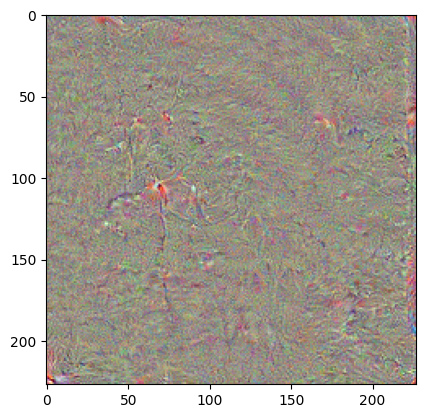

step:  99 activation:  tensor(171.7440, grad_fn=<SelectBackward0>)


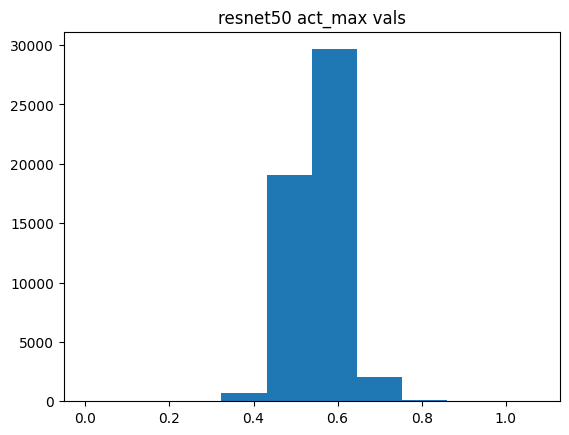

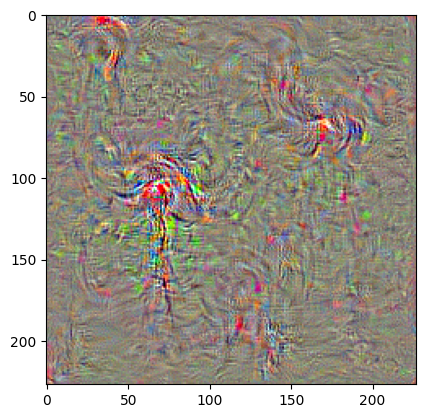

step:  99 activation:  tensor(571.6251, grad_fn=<SelectBackward0>)


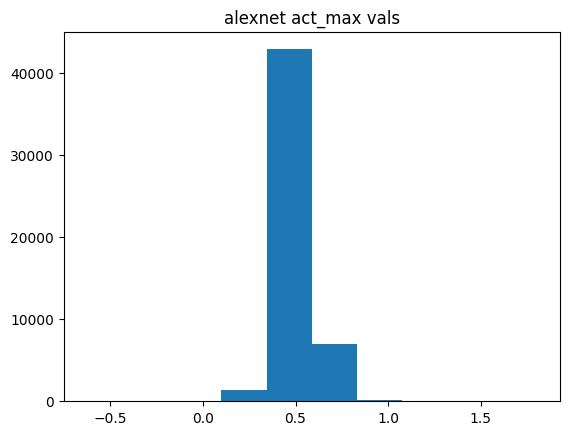

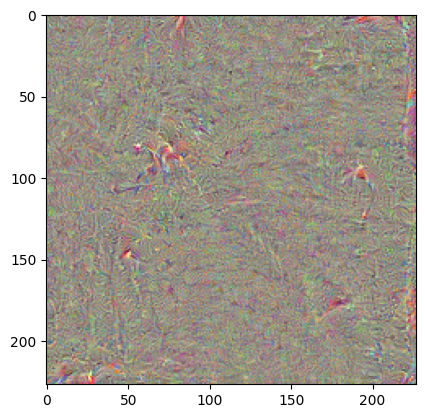

step:  99 activation:  tensor(181.6507, grad_fn=<SelectBackward0>)


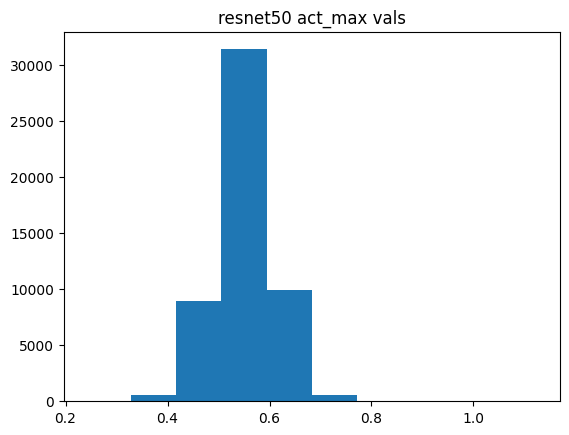

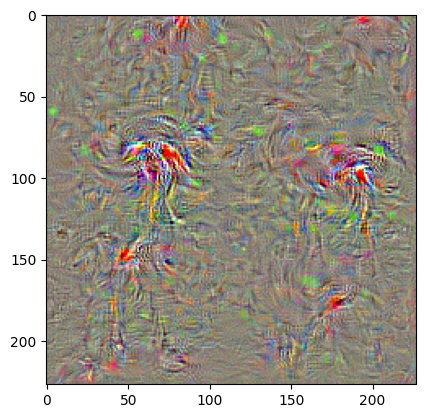

step:  99 activation:  tensor(624.0005, grad_fn=<SelectBackward0>)


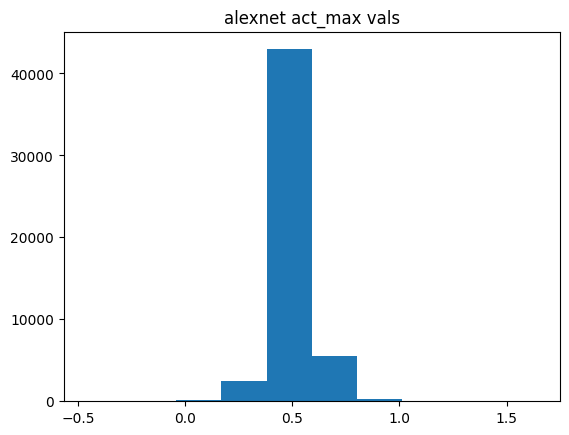

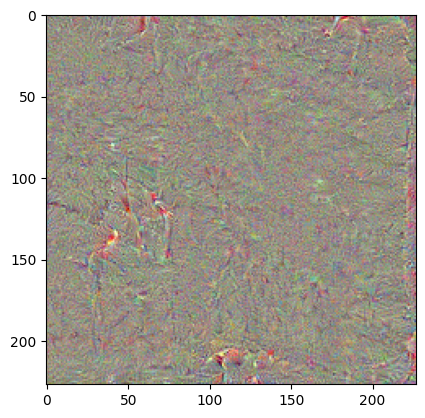

step:  99 activation:  tensor(186.0141, grad_fn=<SelectBackward0>)


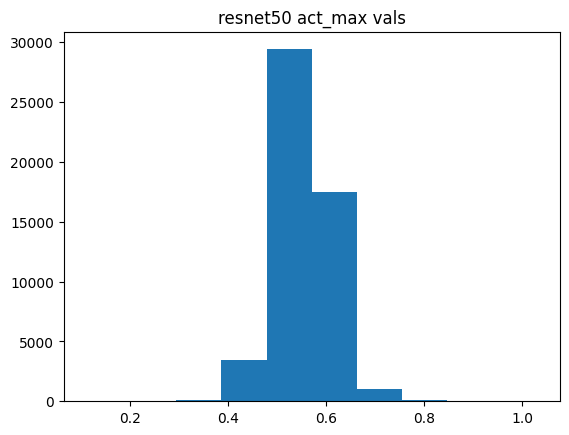

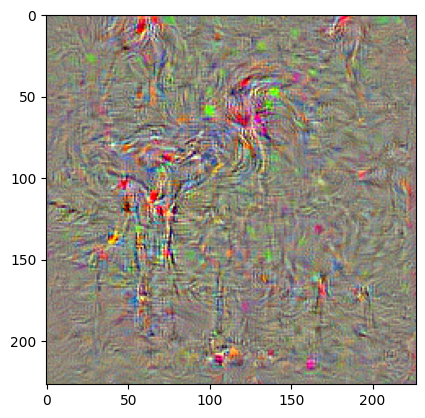

step:  99 activation:  tensor(540.1204, grad_fn=<SelectBackward0>)


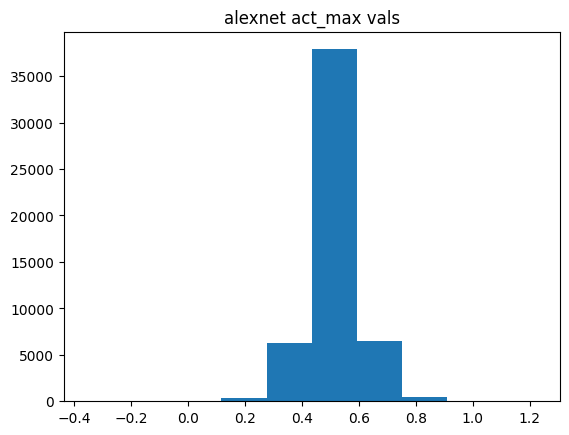

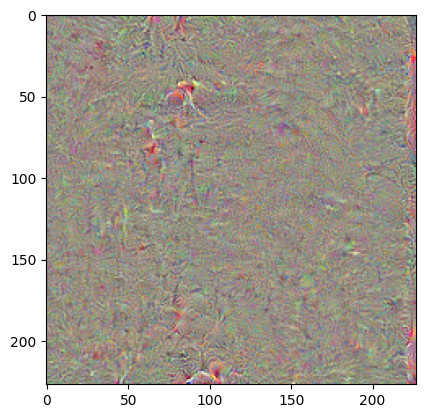

step:  99 activation:  tensor(175.7867, grad_fn=<SelectBackward0>)


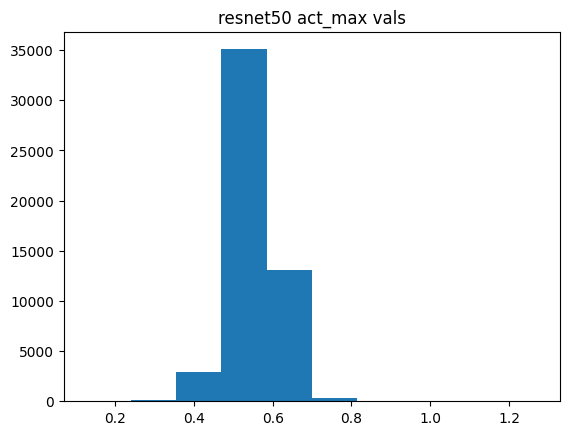

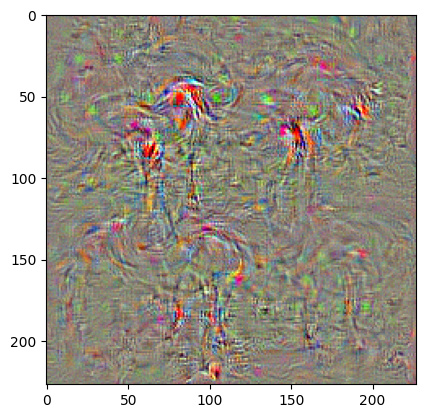

step:  99 activation:  tensor(638.4976, grad_fn=<SelectBackward0>)


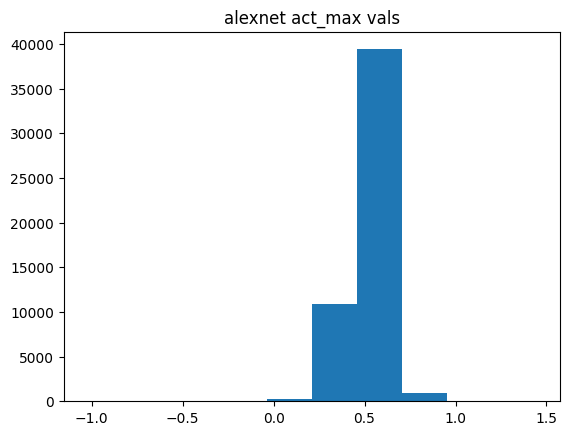

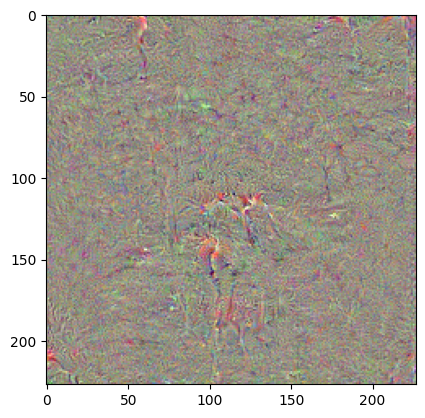

step:  99 activation:  tensor(181.4510, grad_fn=<SelectBackward0>)


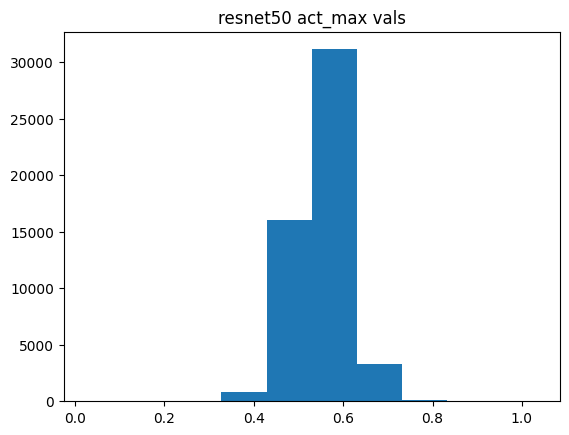

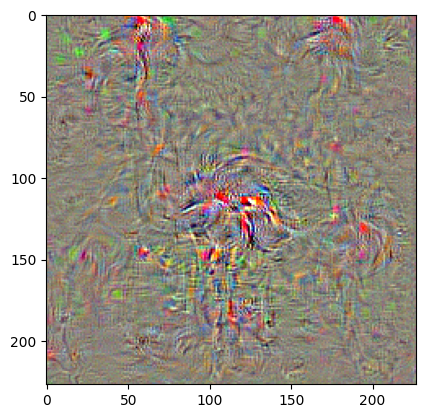

step:  99 activation:  tensor(563.5695, grad_fn=<SelectBackward0>)


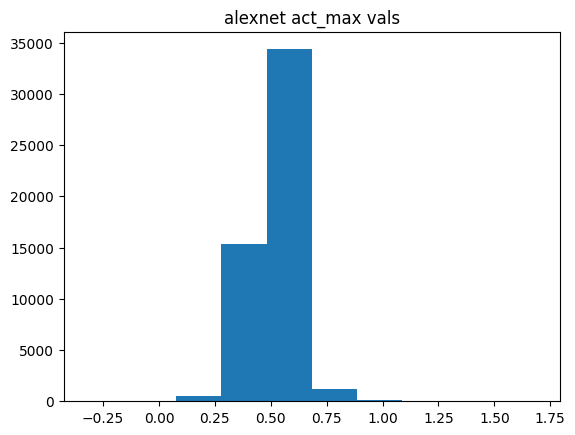

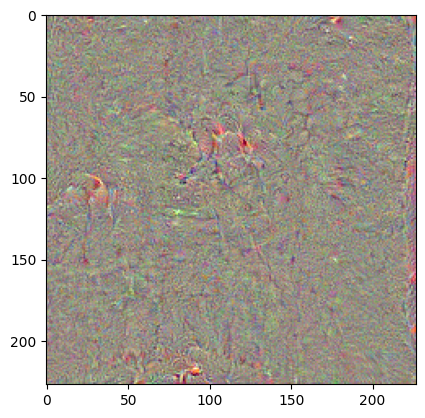

step:  99 activation:  tensor(185.7611, grad_fn=<SelectBackward0>)


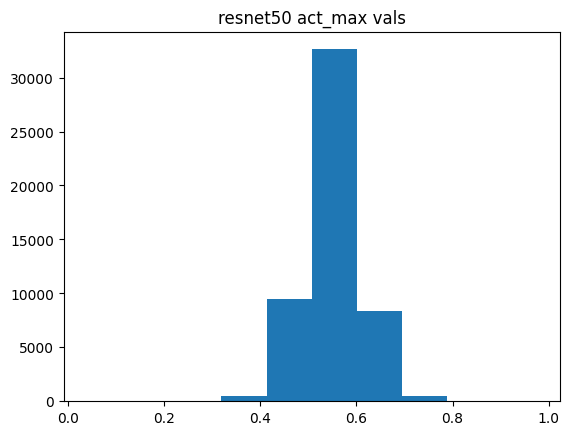

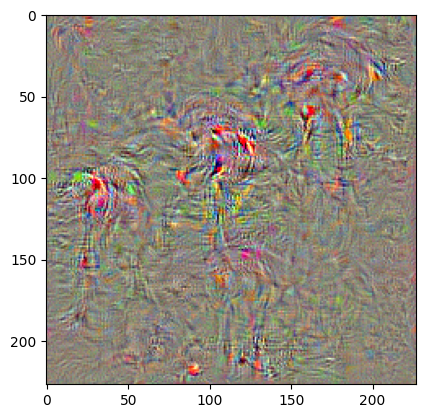

step:  99 activation:  tensor(547.5069, grad_fn=<SelectBackward0>)


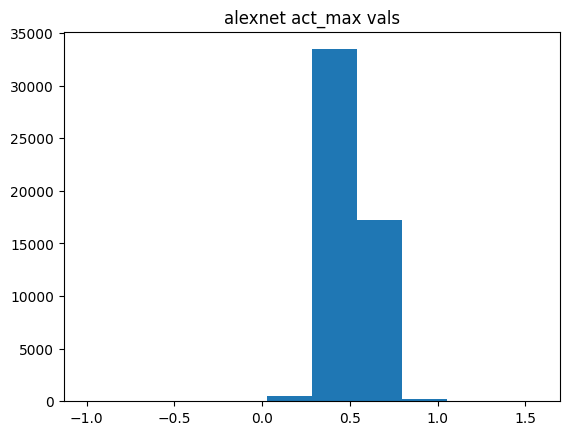

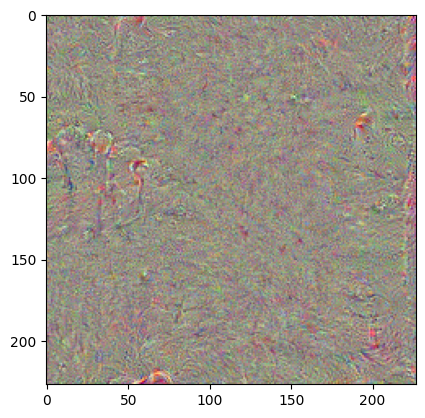

step:  99 activation:  tensor(170.7935, grad_fn=<SelectBackward0>)


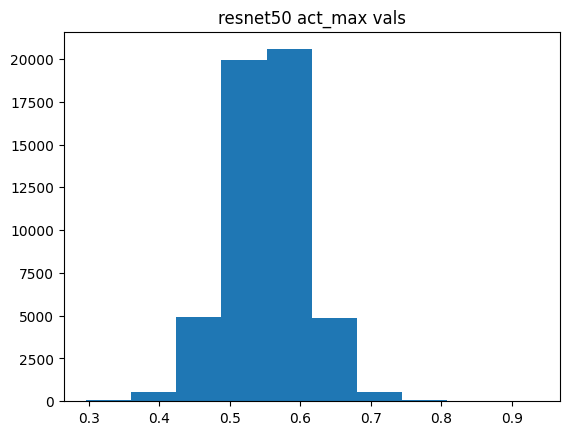

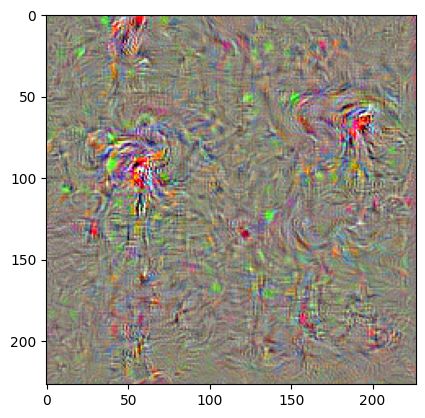

step:  99 activation:  tensor(589.1655, grad_fn=<SelectBackward0>)


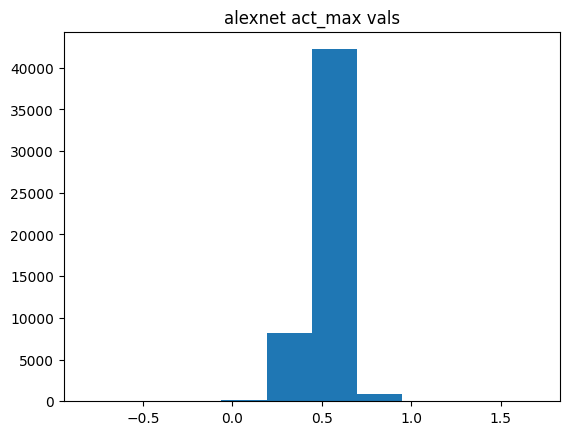

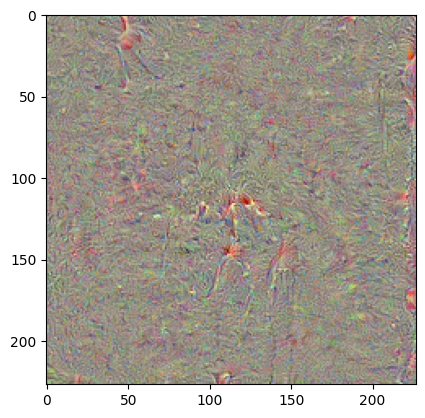

step:  99 activation:  tensor(199.6950, grad_fn=<SelectBackward0>)


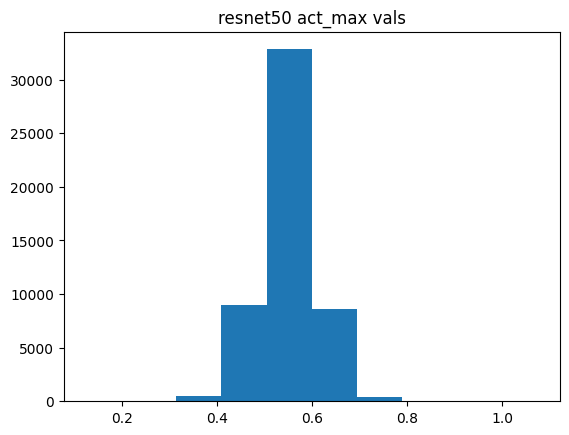

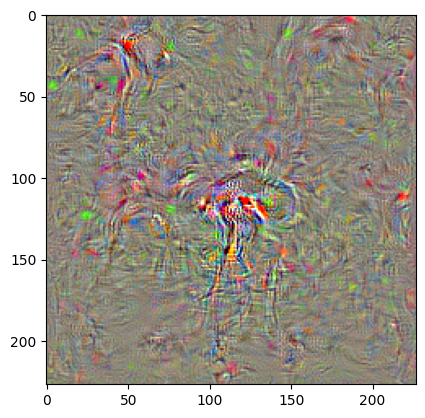

step:  99 activation:  tensor(559.4636, grad_fn=<SelectBackward0>)


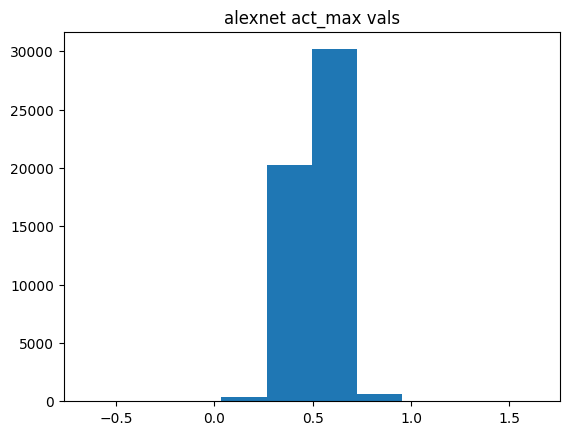

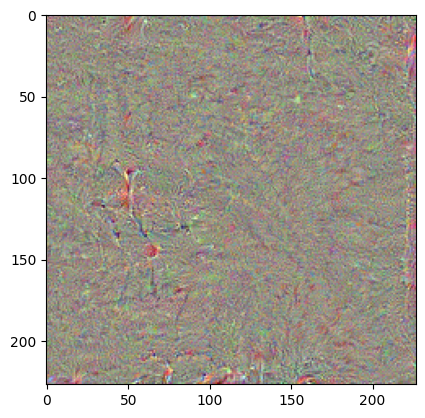

step:  99 activation:  tensor(181.7391, grad_fn=<SelectBackward0>)


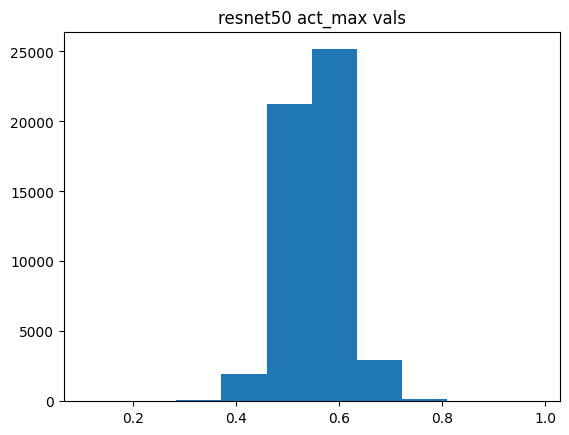

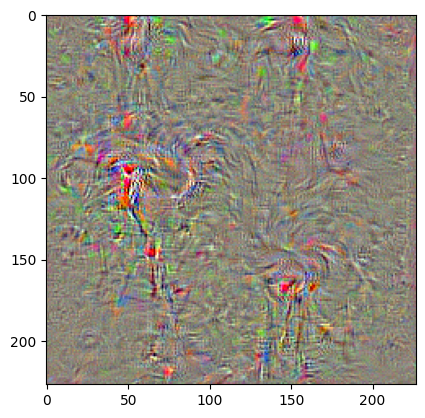

step:  99 activation:  tensor(560.9277, grad_fn=<SelectBackward0>)


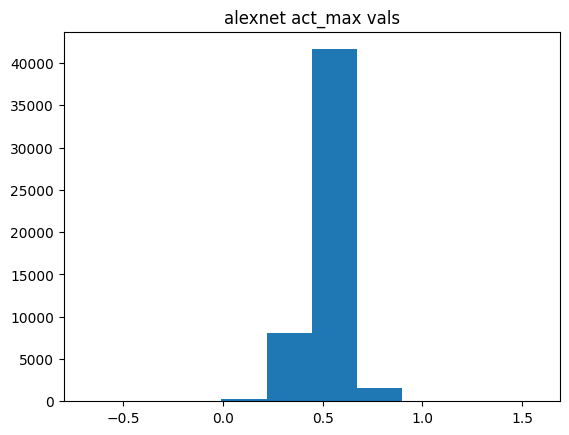

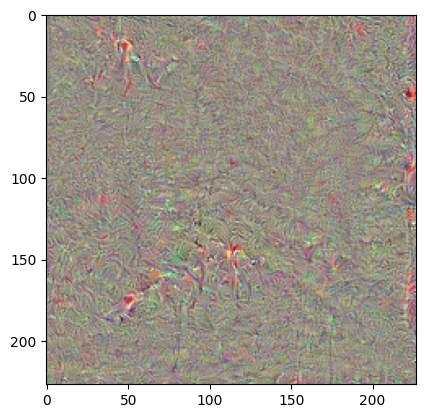

step:  99 activation:  tensor(186.1495, grad_fn=<SelectBackward0>)


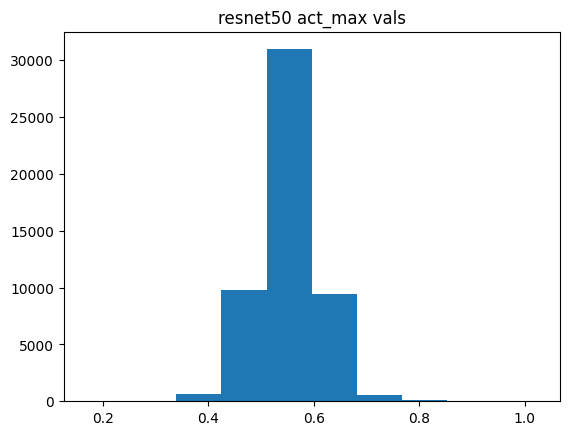

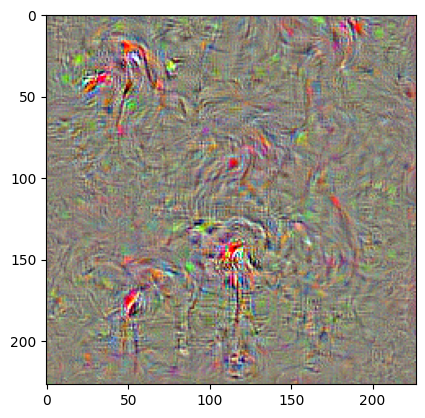

step:  99 activation:  tensor(562.7484, grad_fn=<SelectBackward0>)


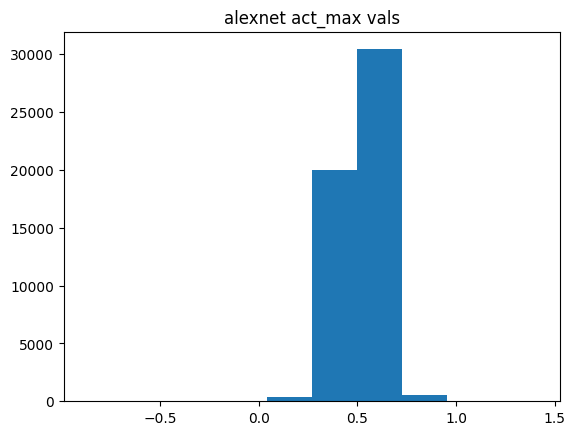

([173.15269470214844,
  181.65072631835938,
  183.74374389648438,
  174.94813537597656,
  183.99583435058594,
  185.72442626953125,
  177.63433837890625,
  197.5602569580078,
  175.3444366455078,
  180.5006103515625],
 [571.6251220703125,
  624.0005493164062,
  536.9176025390625,
  630.7980346679688,
  563.5694580078125,
  539.2625122070312,
  585.6043090820312,
  559.4635620117188,
  560.9276733398438,
  559.6409301757812])

In [64]:
ablation(130, 1, 1, 100, 100, 10)

print(str([205.24777221679688,
  182.0115509033203,
  180.55752563476562,
  188.40090942382812,
  183.72561645507812,
  198.67367553710938,
  178.98355102539062,
  195.13278198242188,
  195.475830078125,
  207.27981567382812]))
print(str([794.1076049804688,
  840.52978515625,
  785.8583374023438,
  748.9758911132812,
  774.743408203125,
  720.02294921875,
  799.399169921875,
  800.5927124023438,
  782.1522216796875,
  758.399169921875]))

## Results of ablation studies
#### Class 130 Flamingo
**alpha=[1,1], steps=[100,100]** [181.7030, 178.2585, 174.4959, 179.2657, 185.1346, 184.0910, 179.5636, 188.8528, 197.5366, 181.2711], [659.6601, 589.0209, 569.0184, 594.9551, 539.6475, 643.0086, 545.7866, 618.2877, 584.8642, 599.2298]  
**alpha=[3,1], steps=[100,100]** [186.82327, 191.20471, 199.08134, 195.60956, 171.30615, 189.96323, 188.02539, 187.90631, 206.27866, 191.98306], [566.293, 502.2811, 622.40424, 531.8228, 585.71564, 659.90424, 565.0917, 578.75507, 547.9594, 581.2964]  
**alpha=[3,3], steps=[100,100]** [205.24777221679688, 182.0115509033203, 180.55752563476562, 188.40090942382812, 183.72561645507812, 198.67367553710938, 178.98355102539062, 195.13278198242188, 195.475830078125, 207.27981567382812], [794.1076049804688, 840.52978515625, 785.8583374023438, 748.9758911132812, 774.743408203125, 720.02294921875, 799.399169921875, 800.5927124023438, 782.1522216796875, 758.399169921875]  
**alpha=[0.5,0.5], steps=[100, 100]** [141.823974609375, 169.8114013671875, 134.5088653564453, 143.23709106445312, 148.24810791015625, 158.42800903320312, 157.01763916015625, 158.23841857910156, 167.502685546875, 139.85076904296875], [372.83160400390625, 376.6695251464844, 327.2226867675781, 306.8876647949219, 348.45562744140625, 354.7510681152344, 317.66058349609375, 349.994140625, 344.1588134765625, 276.2192077636719]  
**alpha=[0.25,0.25], steps=[100, 100]** [114.02588653564453, 115.64485931396484, 128.99899291992188, 112.36042022705078, 121.46685791015625, 125.51639556884766, 111.20305633544922, 121.9969711303711, 118.23275756835938, 127.9784164428711], [158.4856414794922, 105.7464828491211, 186.04202270507812, 171.09332275390625, 92.41614532470703, 159.4355010986328, 155.87635803222656, 166.85520935058594, 143.28294372558594, 130.15419006347656]  
**alpha=[1,1], steps=[25,25]** [58.862709045410156, 82.86116790771484, 63.39403533935547, 71.65101623535156, 79.61209869384766, 73.02263641357422, 64.89652252197266, 65.10323333740234, 65.99878692626953, 81.90188598632812], [129.53187561035156, 164.06700134277344, 118.41835021972656, 108.60730743408203, 166.13514709472656, 109.5059585571289, 153.4026336669922, 95.7031478881836, 97.25186157226562, 141.79197692871094]  
**alpha=[1,1], steps=[50, 50]** [127.60477447509766, 104.6476821899414, 144.02432250976562, 139.62110900878906, 122.55178833007812, 121.30990600585938, 113.28289031982422, 122.46935272216797, 106.99504852294922, 114.76327514648438], [329.513916015625, 312.6715087890625, 352.9454650878906, 410.74462890625, 293.65509033203125, 329.3644714355469, 365.0877685546875, 328.0525817871094, 347.9339904785156, 316.3317565917969]  
**alpha=[1,1], steps=[200, 200]** [237.20846557617188, 214.26710510253906, 246.64663696289062, 238.55401611328125, 224.67236328125, 243.1439208984375, 219.96463012695312, 246.9706573486328, 228.25436401367188, 255.3668212890625], [778.0454711914062, 778.0588989257812, 758.5038452148438, 726.3912353515625, 766.104736328125, 752.3779907226562, 774.57666015625, 775.2931518554688, 793.7871704101562, 725.5020141601562]

#### probably ignore these

In [13]:
# starting image
orig_img = reset_img()
inp = orig_img
# outputs of image through both neural nets
results = [resnet50(inp), alexnet(inp)]
values = [res.detach().numpy() for res in results]
# max outputs of image through both neural nets
ks = [max(v[0]) for v in values]

In [14]:
act_dicts = [{}, {}]
layer_name = 'classifier_final'
(list(resnet50.children())[-1].register_forward_hook(layer_hook(act_dicts[0], layer_name)),
 list(alexnet.children())[-1].register_forward_hook(layer_hook(act_dicts[1], layer_name)))

(<torch.utils.hooks.RemovableHandle at 0x27d0286b650>,
 <torch.utils.hooks.RemovableHandle at 0x27d020ab7d0>)

In [15]:
# which class each network predicted the original image as
units = [list(values[i][0]).index(ks[i]) for i in range(2)]
# If we start with randomized image [0,1], we manually set the target class
# 112: conch
# 130: flamingo
units = [130, 130]
print(units)

[130, 130]


In [ ]:
alpha = torch.tensor(1)
inp = orig_img
# inp = torch.add(orig_img, torch.norm(orig_img, float('inf')), alpha = (-1)*0.1)
activation1, output1 = act_max(model=resnet50,
                inp_img=inp,
                layer_activation=act_dicts[0],
                layer_name=layer_name,
                unit=units[0],
                steps=100,
                alpha=3*alpha,
                )
inp = orig_img
# inp = torch.add(orig_img, torch.norm(orig_img, float('inf')), alpha = (-1)*0.1)
activation2, output2 = act_max(model=alexnet,
                inp_img=inp,
                layer_activation=act_dicts[1],
                layer_name=layer_name,
                unit=units[1],
                steps=100,
                alpha=alpha,
                )